In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [2]:
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

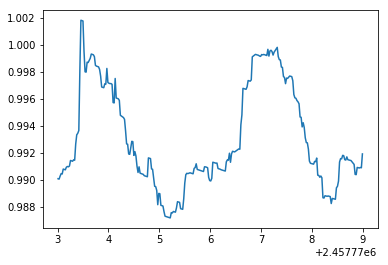

In [3]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 98)
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

plt.plot(k2_time, k2_flux)

std:  0.00118321694268
270 270


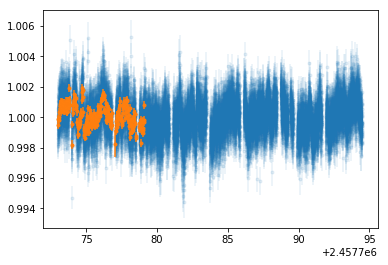

In [41]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_time += k2_time.min() - spitzer_time[0]
spitzer_flux += 1

spitzer_std = np.std(spitzer_flux)
print('std: ', spitzer_std)

from scipy.stats import binned_statistic

#bins = np.arange(spitzer_time.min(), spitzer_time.max(), 1/24)
bins = np.arange(k2_time.min(), k2_time.max()+6*(k2_time[1]-k2_time[0]), k2_time[1]-k2_time[0])
bs1 = binned_statistic(spitzer_time, spitzer_flux, statistic='mean', bins=bins)
bs2 = binned_statistic(spitzer_time, spitzer_flux, statistic='std', bins=bins)
bs3 = binned_statistic(spitzer_time, spitzer_err, statistic='mean', bins=bins)
bs4 = binned_statistic(spitzer_time, spitzer_err, statistic='count', bins=bins)

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.1)

bincenters = 0.5 * (bins[1:] + bins[:-1])

spitzer_times = bincenters
spitzer_fluxes = bs1.statistic
spitzer_errors = bs3.statistic / np.sqrt(bs4.statistic)

spitzer_times = spitzer_times[~np.isnan(spitzer_fluxes)]
spitzer_errors = spitzer_errors[~np.isnan(spitzer_fluxes)]
spitzer_fluxes = spitzer_fluxes[~np.isnan(spitzer_fluxes)]

plt.errorbar(spitzer_times, spitzer_fluxes, spitzer_errors, fmt='.', zorder=100)
print(len(spitzer_times), len(k2_time))

In [42]:
sample_contrast = 1.0

def kepler_to_spitzer_contrast(kepler_contrast):
    sample_temperatures = 2559*u.K + np.arange(-200, 200, 0.5)[:, np.newaxis]*u.K

    # Start with low-res in Kepler bandpass
    bb_trial = blackbody_lambda(kplr_wavelength, sample_temperatures).value
    bb_2559 = blackbody_lambda(kplr_wavelength, 2559*u.K).value
    bb_2600 = blackbody_lambda(kplr_wavelength, 2600).value

    spectrum_interp = np.interp(kplr_wavelength, phoenix_wavelength, phoenix_flux, left=0, right=0)
    spot_trial_spectrum = spectrum_interp * bb_trial / bb_2559

    contrast = (np.trapz(spot_trial_spectrum * kplr_trans * kplr_wavelength, x=kplr_wavelength) / 
                np.trapz(spectrum_interp * kplr_trans * kplr_wavelength, x=kplr_wavelength))

    spot_temperature = sample_temperatures[np.argmin(np.abs(contrast - kepler_contrast))][0]

    # Switch to hi-res for spitzer
    bb_spot = blackbody_lambda(phoenix_wavelength, spot_temperature).value
    bb_2559 = blackbody_lambda(phoenix_wavelength, 2559).value
    bb_2600 = blackbody_lambda(phoenix_wavelength, 2600).value

    trappist_flux = phoenix_flux * bb_2559/bb_2600
    trappist_spot = trappist_flux * bb_spot/bb_2559

    trans_interp = np.interp(phoenix_wavelength, spitz2_wave/10, spitz2_trans, left=0, right=0)

    spitzer_contrast = (np.trapz(trappist_spot * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                        np.trapz(trappist_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))

    return spitzer_contrast

#kepler_contrast_range = np.linspace(0, 2, 100)
#spitzer_contrast_range = np.array([kepler_to_spitzer_contrast(c) for c in kepler_contrast_range])

In [202]:
trappist1_flux = phoenix_flux * bb_2559.value / bb_2600.value

temperature_offsets = np.linspace(-1000, 2000, 20)
kepler_contrast = []
spitzer_contrast = []
for temp_offset in temperature_offsets:
    kplr_trans_interp = np.interp(phoenix_wavelength, kplr_wavelength, kplr_trans, left=0, right=0)
    photosphere_flux_kepler = np.trapz(trappist1_flux * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)
    bb_trial = blackbody_lambda(phoenix_wavelength, 2559 + temp_offset).value
    brightspot_flux = trappist1_flux * bb_trial / bb_2559.value 
    brightspot_flux_kepler = np.trapz(brightspot_flux * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)

    kepler_contrast.append(brightspot_flux_kepler/photosphere_flux_kepler)

    spitzer_trans_interp = np.interp(phoenix_wavelength, spitz2_wave, spitz2_trans, left=0, right=0)
    photosphere_flux_spitzer = np.trapz(trappist1_flux * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)
    brightspot_flux_spitzer = np.trapz(brightspot_flux * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)

    spitzer_contrast.append(brightspot_flux_spitzer / photosphere_flux_spitzer)

    
contrast_p = np.polyfit(kepler_contrast, spitzer_contrast, 10)
    
def kepler_to_spitzer_contrast_interp(kepler_contrast):
    return np.polyval(contrast_p, kepler_contrast)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in multiply
  *arrays, **kwargs)


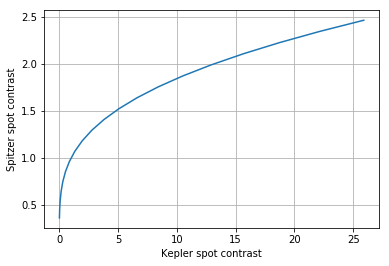

In [297]:
plt.plot(kepler_contrast, spitzer_contrast)
plt.grid()
plt.xlabel('Kepler spot contrast')
plt.ylabel('Spitzer spot contrast')
plt.savefig('kepler_spitzer_contrasts.png', dpi=200)

In [188]:
# plt.plot(kepler_contrast_range, spitzer_contrast_range)
# contrast_p = np.polyfit(kepler_contrast_range, spitzer_contrast_range, 10)

# contrast_p = np.array([ -2.86673787e+00,   3.04324483e+01,  -1.39102663e+02,
#                          3.58168264e+02,  -5.70729646e+02,   5.82371946e+02,
#                         -3.80959509e+02,   1.55908866e+02,  -3.81530016e+01,
#                          5.54607524e+00,   3.85779028e-01])

# def kepler_to_spitzer_contrast_interp(kepler_contrast):
#     return np.polyval(contrast_p, kepler_contrast)

# plt.plot(kepler_contrast_range, np.polyval(contrast_p, kepler_contrast_range), ls='--')
# plt.xlabel('kepler contrast')
# plt.ylabel('spitzer contrast')
# plt.grid()

In [250]:
def model(p, kepler_time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kepler_contrast = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.max(kepler_model_flux)
    kepler_model_flux /= norm_factor
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    #print(spitzer_contrast / kepler_contrast)
    spitzer_model_flux = (kepler_model_flux - 1) * spitzer_contrast / kepler_contrast + 1
    spitzer_model_flux /= np.median(spitzer_model_flux)
    
    return kepler_model_flux, spitzer_model_flux

def chi2(p, kepler_time):
    kepler_model_flux, model_spitzer_flux = model(p, kepler_time)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
    if not (300 < lon0 < 360 and 30 < lon1 < 70 and 190 < lon2 < 280):
#     if not (110 < lon0 < 170 and 200 < lon1 < 300 and 0 < lon2 < 80): # dark
        return -np.inf
    if not (1 < contrast < 100):
        return -np.inf
    return 0

def lnprob(p, kepler_time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, kepler_time)

initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 20])
ndim, nwalkers = 10, 40
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

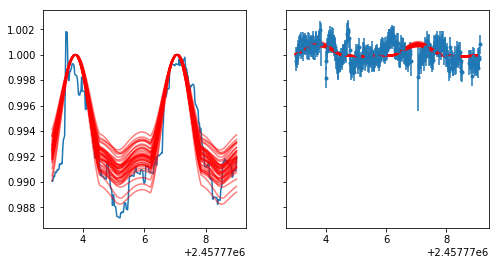

In [230]:

# # dark spots
# initp = np.array([  0.00000000e+00,   145,  0.2,
#                     0.00000000e+00,   225,  0.2,
#                     0.00000000e+00,   70,   0.2, 
#                     0.9])

# bright spots
# initp = np.array([0, 330, 0.4, 
#                   0,  50, 0.2, 
#                   0, 210, 0.2, 1.05])
# initp = np.array([0, 330, 0.07, 
#                   0,  50, 0.04, 
#                   0, 210, 0.04, 3])
initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 20])
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].plot(k2_time, k2_flux)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*3, fmt='.')
for p in pos:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
    ax[0].plot(k2_time, model_k2_fluxes, color='r', alpha=0.5)
    ax[1].plot(k2_time, model_spitzer_flux, color='r', alpha=0.5)
    #print(model_spitzer_std, spitzer_std)

In [231]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, ), 
                                threads=4)
sampler.run_mcmc(pos, 1500);

In [232]:
# sampler.run_mcmc(pos, 1500);

In [233]:
n_burnin = 1000
samples = samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
# samples = sampler.flatchain

In [298]:
#np.savetxt('posteriors_bright_spot.txt', samples)

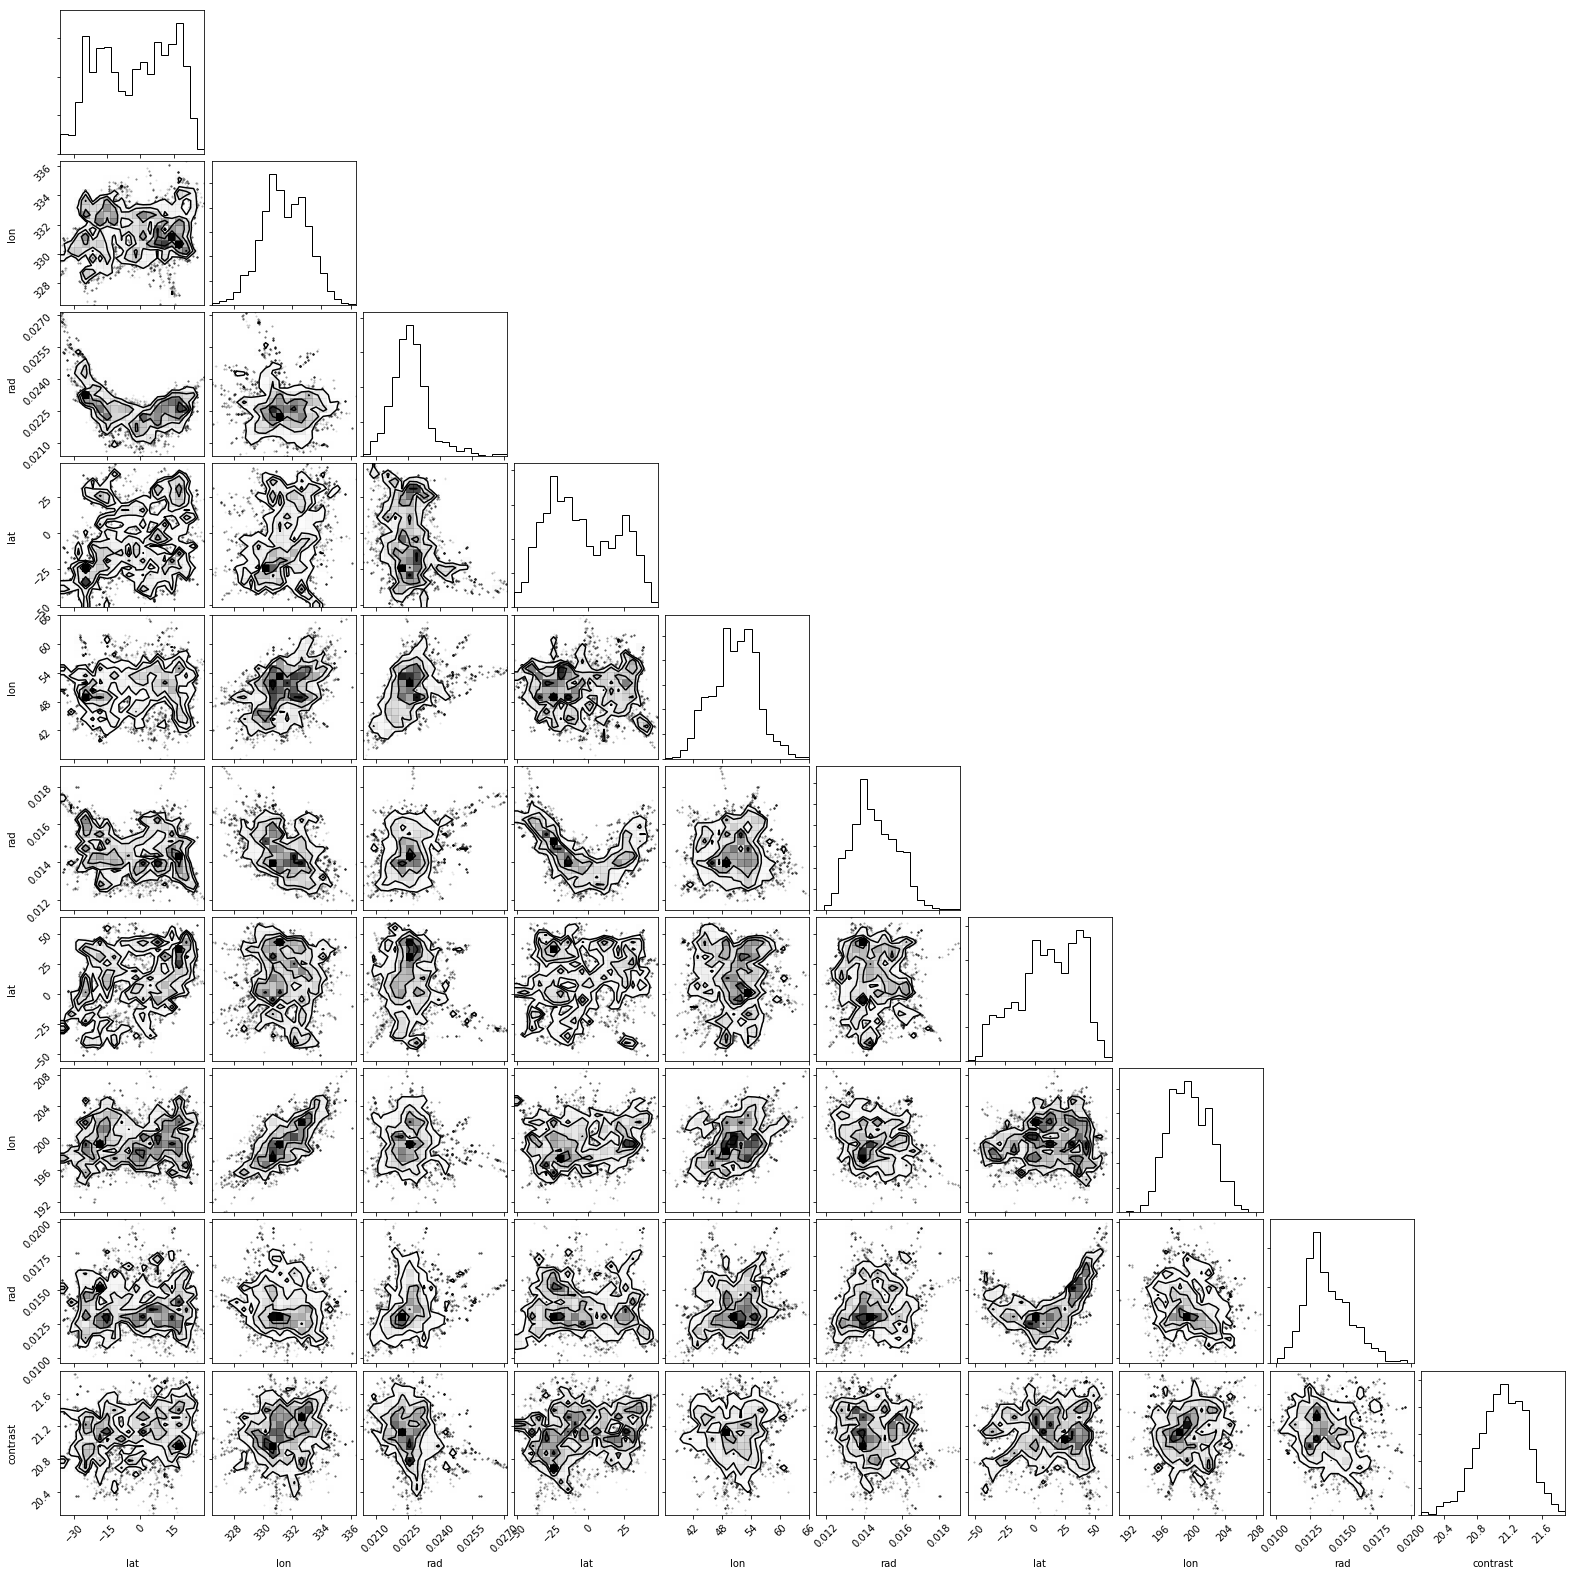

In [285]:
labels = ['lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'contrast']
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner_bright_spitzer.png', bbox_inches='tight', dpi=250)
plt.show()

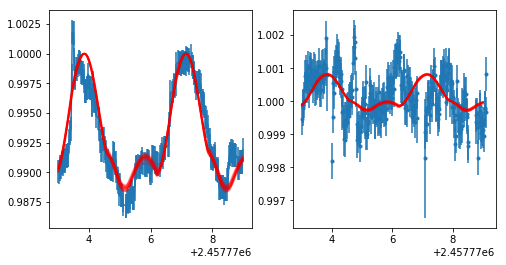

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.')
for p in samples[np.random.randint(0, samples.shape[0], 50), :]:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
    ax[0].plot(k2_time, model_k2_fluxes, alpha=0.1, color='r', zorder=10)
    ax[1].plot(k2_time, model_spitzer_flux, alpha=0.1, color='r', zorder=10)
    #print(model_spitzer_std, spitzer_std)

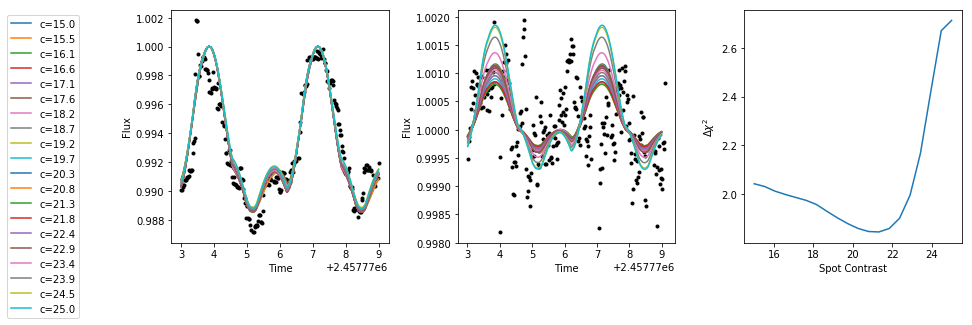

In [293]:
from scipy.optimize import fmin_tnc

def model_d(p, kepler_time, kepler_contrast):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2  = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.max(kepler_model_flux)
    kepler_model_flux /= norm_factor
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    #print(spitzer_contrast / kepler_contrast)
    spitzer_model_flux = (kepler_model_flux - 1) * spitzer_contrast / kepler_contrast + 1
    spitzer_model_flux /= np.median(spitzer_model_flux)
    
    return kepler_model_flux, spitzer_model_flux

def chi2_d(p, kepler_time, kepler_contrast):
    kepler_model_flux, model_spitzer_flux = model_d(p, kepler_time, kepler_contrast)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008])

bounds = [[-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1]]

reduced_chi2 = []
contrasts = np.linspace(15, 25, 20)
results = []
dof = 9

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(k2_time, k2_flux, '.k')

ax[1].plot(spitzer_times, spitzer_fluxes, '.k')


from astropy.utils.console import ProgressBar

with ProgressBar(len(contrasts), ipython_widget=True) as bar:
    median_radius = []

    for i, contrast in enumerate(contrasts):
        if i > 0:
            initp = results[-1] #+ 0.01 * np.random.randn()
        result = fmin_tnc(chi2_d, initp, args=(k2_time, contrast), bounds=bounds, disp=True,
                  approx_grad=True)[0]
        k_model, s_model = model_d(result, k2_time, contrast)
        red_chi2 = ((np.sum((k_model - k2_flux)**2 / (2*k2_err)**2) + 
                     np.sum((s_model - spitzer_fluxes)**2 / (2*spitzer_errors)**2)) / 
                    (2*len(k2_time) - dof))
        reduced_chi2.append(red_chi2)
        results.append(result)
        median_radius.append(np.median(result[2::3]))
        bar.update()

        ax[0].plot(k2_time, k_model, label="c={0:.1f}".format(contrast))
        ax[1].plot(k2_time, s_model)


        #ax[1].plot(contrasts, median_radius)

ax[0].legend(bbox_to_anchor=(-1.4, 0, 1., 1))

ax[2].plot(contrasts, reduced_chi2)

ax[0].set(xlabel='Time', ylabel='Flux')

ax[1].set(xlabel='Time', ylabel='Flux')


ax[2].set(xlabel='Spot Contrast', ylabel='$\Delta \chi^2$')
fig.tight_layout()
fig.savefig('degeneracy_bright_spot.pdf', bbox_inches='tight')
plt.show()

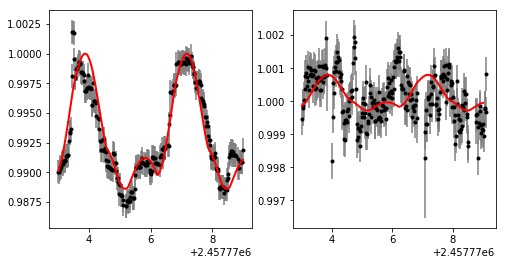

In [256]:
best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]
best_model_k2, best_model_sp = model(p, k2_time)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray')
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.', color='k', ecolor='gray')

ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2)
ax[1].plot(k2_time, best_model_sp, color='r', zorder=10, lw=2)

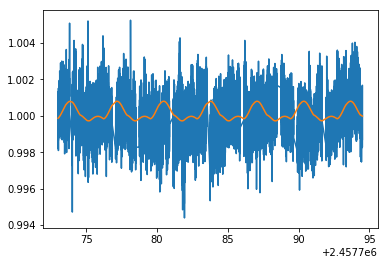

In [259]:
extended_model_k2, extended_model_sp = model(p, spitzer_time)



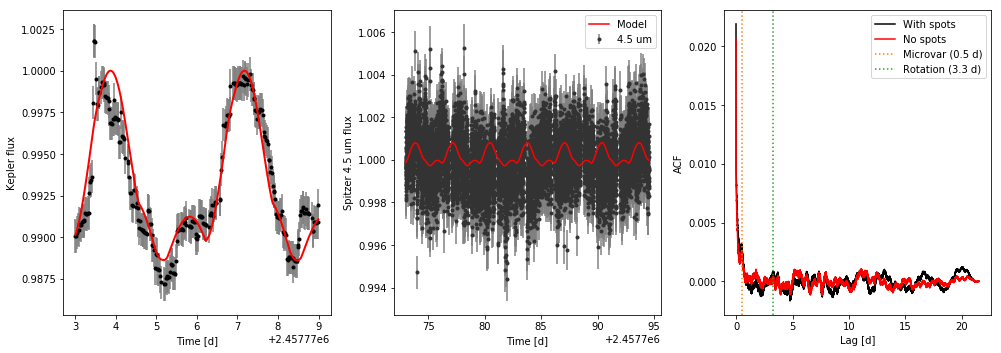

In [284]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux + (extended_model_sp - 1) - 1)

lag_nospots, acf_nospots = interpolated_acf(spitzer_time, spitzer_flux - 1)

best_period = dominant_period(lag, acf)

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray')
ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2)
ax[0].set(xlabel='Time [d]', ylabel='Kepler flux')

ax[1].errorbar(spitzer_time, spitzer_flux, spitzer_err, label='4.5 um', fmt='.', color='#333333', ecolor='gray')
ax[1].plot(spitzer_time, extended_model_sp, label='Model', color='r', zorder=10)
ax[1].legend()

ax[2].plot(lag, acf, color='k', label='With spots')
ax[2].plot(lag_nospots, acf_nospots, color='r', label='No spots')

ax[2].set_xlabel('Lag [d]')
ax[2].set_ylabel('ACF')
ax[1].set(xlabel='Time [d]', ylabel='Spitzer 4.5 um flux')
ax[2].axvline(0.5, ls=':', color='C1', label='Microvar (0.5 d)')
ax[2].axvline(3.3, ls=':', color='C2', label='Rotation (3.3 d)')
ax[2].legend()

fig.tight_layout()
fig.savefig('best_bright_spot_model.png', bbox_inches='tight', dpi=250)

In [296]:
np.sum(np.pi*best_params[2::3]**2 / (4 * np.pi))

0.00025232540747740985